In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# **1. Load and Explore Data**

In [2]:
# Load data
df = pd.read_csv('churn.csv')

In [3]:
print("Data Overview:")
print("-" * 20)
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

Data Overview:
--------------------
Dataset shape: (500, 10)
Missing values: 0


In [4]:
print("\nColumn names:")
print(df.columns.tolist())


Column names:
['customer_id', 'num_orders', 'avg_order_value', 'last_order_days_ago', 'discount_used', 'subscription', 'customer_support_calls', 'delivery_issues', 'payment_issues', 'churned']


In [5]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   customer_id  num_orders  avg_order_value  last_order_days_ago  \
0            1          39            68.48                  104   
1            2          29            14.33                  176   
2            3          15            95.42                  147   
3            4          43            89.80                  117   
4            5           8            33.48                   85   

   discount_used  subscription  customer_support_calls  delivery_issues  \
0              1             0                       1                4   
1              0             0                       2                3   
2              1             0                       7                3   
3              0             0                       9                2   
4              0             0                       5                1   

   payment_issues  churned  
0               0        1  
1               0        1  
2               1        1  
3        

In [6]:
print("\nBasic statistics:")
print(df.describe())


Basic statistics:
       customer_id  num_orders  avg_order_value  last_order_days_ago  \
count   500.000000  500.000000       500.000000           500.000000   
mean    250.500000   25.678000        55.834280            96.420000   
std     144.481833   14.127898        25.364873            58.686658   
min       1.000000    1.000000        10.230000             0.000000   
25%     125.750000   14.000000        33.475000            45.000000   
50%     250.500000   26.000000        57.980000            97.000000   
75%     375.250000   37.000000        76.792500           147.250000   
max     500.000000   49.000000        99.790000           199.000000   

       discount_used  subscription  customer_support_calls  delivery_issues  \
count     500.000000    500.000000              500.000000       500.000000   
mean        0.528000      0.514000                4.484000         2.058000   
std         0.499715      0.500305                2.828027         1.409471   
min         0.00

In [7]:
print(f"\nChurn distribution:")
print(df['churned'].value_counts())
print(f"Churn rate: {df['churned'].mean():.1%}")


Churn distribution:
churned
1    292
0    208
Name: count, dtype: int64
Churn rate: 58.4%


# **2. Exploratory Data Analysis with Visualizations**

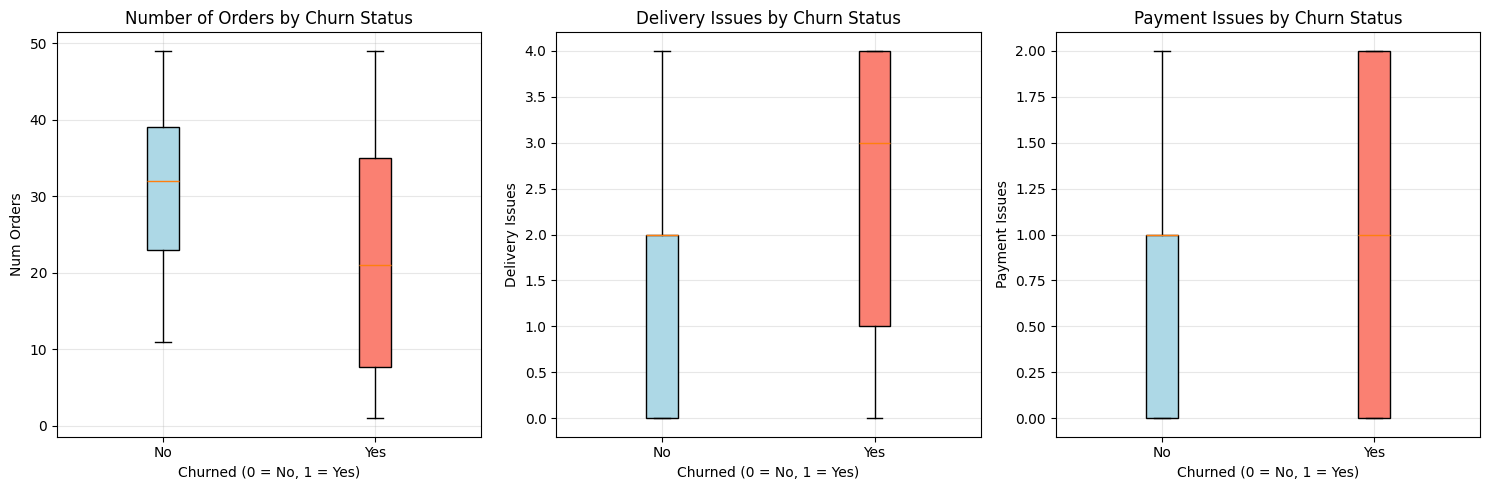

In [8]:
# Create boxplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

features = ['num_orders', 'delivery_issues', 'payment_issues']
titles = ['Number of Orders by Churn Status',
          'Delivery Issues by Churn Status',
          'Payment Issues by Churn Status']

for i, (feature, title) in enumerate(zip(features, titles)):
    # Create boxplot
    churned_data = [df[df['churned'] == 0][feature], df[df['churned'] == 1][feature]]
    box_plot = axes[i].boxplot(churned_data, labels=['No', 'Yes'],
                               patch_artist=True)

    # Color the boxes
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('salmon')

    axes[i].set_title(title)
    axes[i].set_xlabel('Churned (0 = No, 1 = Yes)')
    axes[i].set_ylabel(feature.replace('_', ' ').title())
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **3. Statistical Tests (T-tests)**

In [9]:
# Perform t-tests for each feature
features_to_test = ['num_orders', 'delivery_issues', 'payment_issues']

for feature in features_to_test:
    # Separate data by churn status
    group_0 = df[df['churned'] == 0][feature]
    group_1 = df[df['churned'] == 1][feature]

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1)

    # Calculate means
    mean_0 = group_0.mean()
    mean_1 = group_1.mean()

    print(f"\nT-test for {feature.replace('_', ' ').title()}:")
    print(f"  Mean (Not Churned): {mean_0:.2f}")
    print(f"  Mean (Churned): {mean_1:.2f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Significant: {'Yes' if p_value < 0.001 else 'No'}")


T-test for Num Orders:
  Mean (Not Churned): 31.16
  Mean (Churned): 21.77
  T-statistic: 7.7414
  P-value: 5.53e-14
  Significant: Yes

T-test for Delivery Issues:
  Mean (Not Churned): 1.60
  Mean (Churned): 2.39
  T-statistic: -6.4290
  P-value: 3.01e-10
  Significant: Yes

T-test for Payment Issues:
  Mean (Not Churned): 0.79
  Mean (Churned): 1.12
  T-statistic: -4.3878
  P-value: 1.40e-05
  Significant: Yes


# **4. Data Preparation for Modeling**

In [10]:
# Split data into features and target
X = df[['num_orders', 'delivery_issues', 'payment_issues']]
y = df['churned']

# Split into training and testing sets (80/20 split, same as R code)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training set churn rate: {y_train.mean():.1%}")
print(f"Testing set churn rate: {y_test.mean():.1%}")

Training set size: 400
Testing set size: 100
Training set churn rate: 58.5%
Testing set churn rate: 58.0%


# **5. Model 1: Single Predictor (Delivery Issues)**

In [11]:
# Train model with only delivery issues
model1 = LogisticRegression(random_state=42, max_iter=1000)
model1.fit(X_train[['delivery_issues']], y_train)

# Make predictions
y_pred1 = model1.predict(X_test[['delivery_issues']])
y_pred1_proba = model1.predict_proba(X_test[['delivery_issues']])[:, 1]

# Calculate performance metrics
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1, zero_division=0)
recall1 = recall_score(y_test, y_pred1, zero_division=0)
f1_1 = f1_score(y_test, y_pred1, zero_division=0)

print(f"Model 1 Performance:")
print(f"  Accuracy: {accuracy1:.3f}")
print(f"  Precision: {precision1:.3f}")
print(f"  Recall: {recall1:.3f}")
print(f"  F1 Score: {f1_1:.3f}")

print(f"\nConfusion Matrix for Model 1:")
cm1 = confusion_matrix(y_test, y_pred1)
print("         Predicted")
print("         0    1")
print(f"Actual 0 {cm1[0,0]:3d}  {cm1[0,1]:3d}")
print(f"       1 {cm1[1,0]:3d}  {cm1[1,1]:3d}")

Model 1 Performance:
  Accuracy: 0.540
  Precision: 0.591
  Recall: 0.672
  F1 Score: 0.629

Confusion Matrix for Model 1:
         Predicted
         0    1
Actual 0  15   27
       1  19   39


# **6. Model 2: Multiple Predictors**

In [12]:
# Train model with all features
model2 = LogisticRegression(random_state=42, max_iter=1000)
model2.fit(X_train, y_train)

# Make predictions
y_pred2 = model2.predict(X_test)
y_pred2_proba = model2.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2, zero_division=0)
recall2 = recall_score(y_test, y_pred2, zero_division=0)
f1_2 = f1_score(y_test, y_pred2, zero_division=0)

print(f"Model 2 Performance:")
print(f"  Accuracy: {accuracy2:.3f}")
print(f"  Precision: {precision2:.3f}")
print(f"  Recall: {recall2:.3f}")
print(f"  F1 Score: {f1_2:.3f}")

print(f"\nConfusion Matrix for Model 2:")
cm2 = confusion_matrix(y_test, y_pred2)
print("         Predicted")
print("         0    1")
print(f"Actual 0 {cm2[0,0]:3d}  {cm2[0,1]:3d}")
print(f"       1 {cm2[1,0]:3d}  {cm2[1,1]:3d}")

print(f"\nModel 2 Coefficients:")
print(f"  Intercept: {model2.intercept_[0]:.4f}")
feature_names = ['delivery_issues', 'payment_issues', 'num_orders']
coef_mapping = {'delivery_issues': 1, 'payment_issues': 2, 'num_orders': 0}
for feature in feature_names:
    coef_idx = coef_mapping[feature]
    print(f"  {feature.replace('_', ' ').title()}: {model2.coef_[0][coef_idx]:.4f}")

Model 2 Performance:
  Accuracy: 0.710
  Precision: 0.738
  Recall: 0.776
  F1 Score: 0.756

Confusion Matrix for Model 2:
         Predicted
         0    1
Actual 0  26   16
       1  13   45

Model 2 Coefficients:
  Intercept: 0.2969
  Delivery Issues: 0.5065
  Payment Issues: 0.5997
  Num Orders: -0.0572


# **7. Model Comparison**

In [13]:
print(f"Model 1 - Accuracy: {accuracy1:.3f}")
print(f"Model 1 - Precision: {precision1:.3f}")
print(f"Model 1 - Recall: {recall1:.3f}")
print(f"Model 1 - F1 Score: {f1_1:.3f}")

print(f"\nModel 2 - Accuracy: {accuracy2:.3f}")
print(f"Model 2 - Precision: {precision2:.3f}")
print(f"Model 2 - Recall: {recall2:.3f}")
print(f"Model 2 - F1 Score: {f1_2:.3f}")

print(f"\nImprovement from Model 1 to Model 2:")
print(f"  Accuracy: +{(accuracy2 - accuracy1)*100:.1f} percentage points")
print(f"  F1 Score: +{(f1_2 - f1_1)*100:.1f} percentage points")

# Statistical comparison using likelihood ratio test (similar to ANOVA in R)
from sklearn.metrics import log_loss
ll1 = -log_loss(y_test, y_pred1_proba, normalize=False)
ll2 = -log_loss(y_test, y_pred2_proba, normalize=False)
lr_stat = 2 * (ll2 - ll1)
p_value_lr = stats.chi2.sf(lr_stat, df=2)  # 2 degrees of freedom difference
print(f"\nLikelihood Ratio Test (similar to ANOVA):")
print(f"  LR Statistic: {lr_stat:.4f}")
print(f"  P-value: {p_value_lr:.2e}")

Model 1 - Accuracy: 0.540
Model 1 - Precision: 0.591
Model 1 - Recall: 0.672
Model 1 - F1 Score: 0.629

Model 2 - Accuracy: 0.710
Model 2 - Precision: 0.738
Model 2 - Recall: 0.776
Model 2 - F1 Score: 0.756

Improvement from Model 1 to Model 2:
  Accuracy: +17.0 percentage points
  F1 Score: +12.7 percentage points

Likelihood Ratio Test (similar to ANOVA):
  LR Statistic: 21.9004
  P-value: 1.76e-05


# **8. Visualizations**

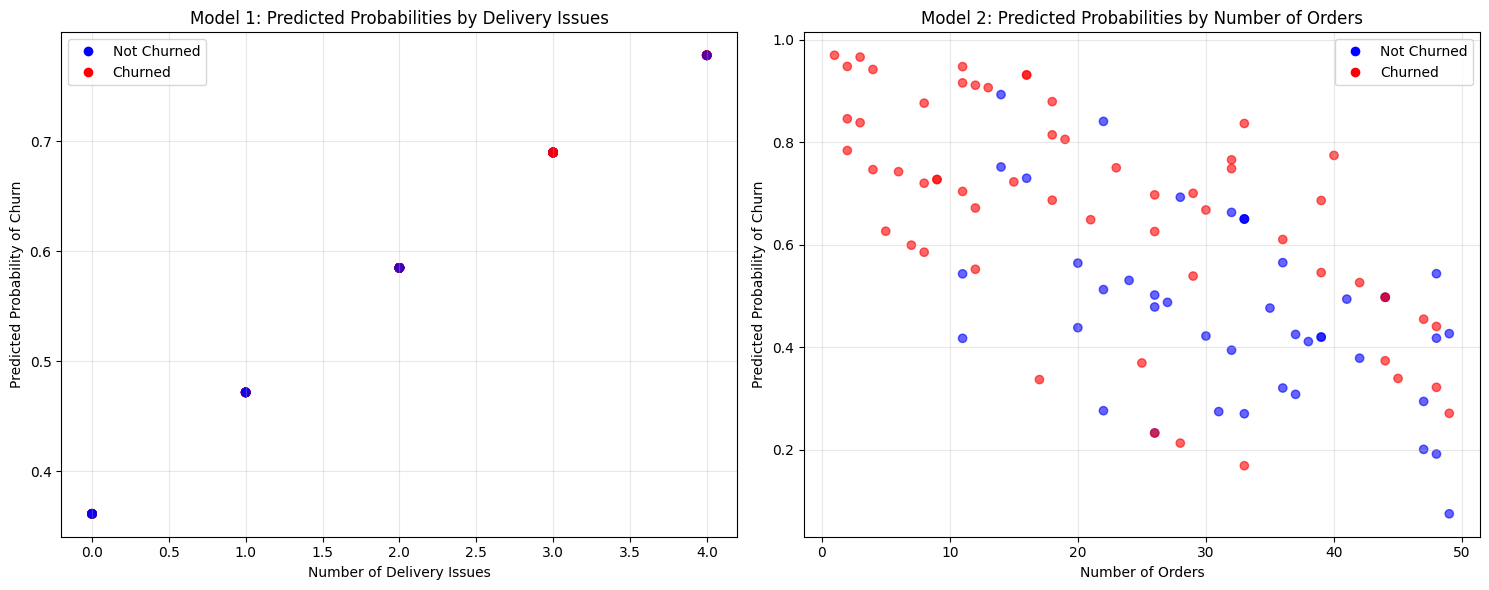

In [14]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model 1 - Predicted Probabilities by Delivery Issues
colors = ['blue' if y == 0 else 'red' for y in y_test]
axes[0].scatter(X_test['delivery_issues'], y_pred1_proba, c=colors, alpha=0.6)
axes[0].set_xlabel('Number of Delivery Issues')
axes[0].set_ylabel('Predicted Probability of Churn')
axes[0].set_title('Model 1: Predicted Probabilities by Delivery Issues')
axes[0].grid(True, alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                         markersize=8, label='Not Churned'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                         markersize=8, label='Churned')]
axes[0].legend(handles=legend_elements, loc='upper left')

# Plot 2: Model 2 - Predicted Probabilities by Number of Orders
colors = ['blue' if y == 0 else 'red' for y in y_test]
axes[1].scatter(X_test['num_orders'], y_pred2_proba, c=colors, alpha=0.6)
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Predicted Probability of Churn')
axes[1].set_title('Model 2: Predicted Probabilities by Number of Orders')
axes[1].grid(True, alpha=0.3)
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()